In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# Path to frame directory (update as needed)
frames_dir = 'data/images'

# Load all available frames with .csv extension
frame_files = sorted([f for f in os.listdir(frames_dir) if f.startswith('Frame_') and f.endswith('.csv')])

# Initialize data structure
all_data = []

# Load frame data into memory
for file_name in frame_files:
    file_path = os.path.join(frames_dir, file_name)
    frame_data = pd.read_csv(file_path, header=None)
    all_data.append(frame_data.values)

# Flatten and convert data for model training
all_data = np.array(all_data).reshape(len(all_data), -1)  # Flatten each frame

# Treat 0s as missing values by replacing them with NaN
all_data[all_data == 0] = np.nan

# Use mean imputation to replace NaNs with the column-wise mean
imputer = SimpleImputer(strategy="mean")
all_data = imputer.fit_transform(all_data)

# Normalize data
scaler = MinMaxScaler()
all_data = scaler.fit_transform(all_data)



/Users/berkeayyildizli/ENS_Graduation_Project/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [  0   1 202]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Reduced data shape (after PCA): (1564, 50)


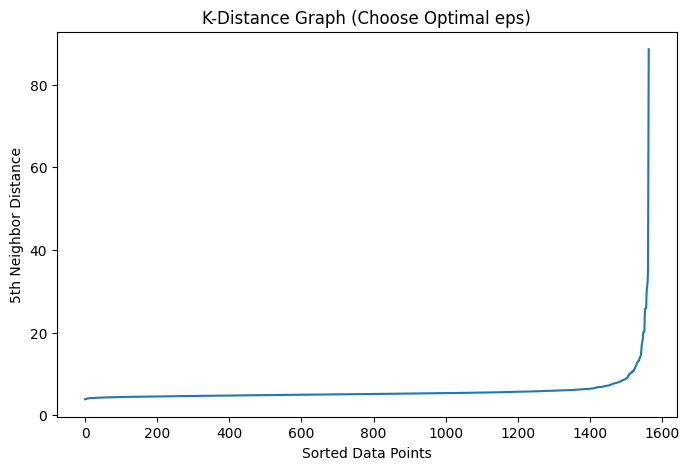

DBSCAN clustering completed. Anomalies detected: 71


In [3]:
# **Step 2: Reduce Dimensionality with PCA (Important for DBSCAN)**
pca = PCA(n_components=50)  # Reduce 40,000+ dimensions to 50
all_data_pca = pca.fit_transform(all_data)
print(f"Reduced data shape (after PCA): {all_data_pca.shape}")

# **Step 3: Find the Optimal eps using K-Nearest Neighbors**
neigh = NearestNeighbors(n_neighbors=5, metric="euclidean")
neigh.fit(all_data_pca)
distances, indices = neigh.kneighbors(all_data_pca)

# Sort the 5th neighbor distances (DBSCAN heuristic)
sorted_distances = np.sort(distances[:, -1])

# Plot the K-distance graph
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.xlabel("Sorted Data Points")
plt.ylabel("5th Neighbor Distance")
plt.title("K-Distance Graph (Choose Optimal eps)")
plt.show()

# **Step 4: Apply DBSCAN with Optimized Parameters**
eps_value = 7.7  # Based on the elbow point in the graph
min_samples_value = 5  # Keep this low to allow small clusters

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric="euclidean")
labels = dbscan.fit_predict(all_data_pca)

# Mark anomalies (DBSCAN labels noise as -1)
anomaly_predictions = (labels == -1).astype(int)

# Store results in a DataFrame
dbscan_results = pd.DataFrame({"Frame": frame_files, "Anomaly": anomaly_predictions})
dbscan_results.to_csv("dbscan_results.csv", index=False)
print(f"DBSCAN clustering completed. Anomalies detected: {np.sum(anomaly_predictions)}")

In [4]:
# **Optional: Evaluation if ground truth labels are available**
labels_path = 'data/frame_porosity_labels.csv'
if os.path.exists(labels_path):
    labels_data = pd.read_csv(labels_path)

    # Clean column names
    labels_data.columns = labels_data.columns.str.strip()
    labels_data.rename(columns={"Frame": "Frame", "Porosity Label": "Label"}, inplace=True)

    # Ensure matching frame names
    labels_data["Frame"] = labels_data["Frame"].astype(str).apply(lambda x: f"Frame_{x}.csv")

    # Merge predictions with ground truth
    merged_data = pd.merge(dbscan_results, labels_data, on="Frame", how="inner")

    if merged_data.shape[0] == 0:
        print("Error: No matching frames between DBSCAN results and labels data!")
    else:
        # Evaluate DBSCAN against labels
        accuracy = accuracy_score(merged_data["Label"], merged_data["Anomaly"])
        conf_matrix = confusion_matrix(merged_data["Label"], merged_data["Anomaly"])
        classification_rep = classification_report(merged_data["Label"], merged_data["Anomaly"])

        print("\nDBSCAN Evaluation:")
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(classification_rep)



DBSCAN Evaluation:
Accuracy: 0.96
Confusion Matrix:
[[1461   32]
 [  32   39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1493
           1       0.55      0.55      0.55        71

    accuracy                           0.96      1564
   macro avg       0.76      0.76      0.76      1564
weighted avg       0.96      0.96      0.96      1564

